### LBGM에 쓰이는 함수를 조금 추가하고 싶어서(정규화/표준화/차원축소) 따로 만들었음
### 기존의 전처리 함수 + 추가적 전처리 함수를 모아놓을 예정

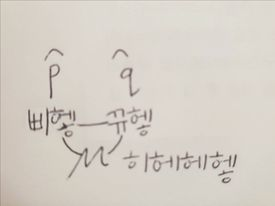

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
!pip install import_ipynb
import import_ipynb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_use = ['Time', 'DHI','DNI','RH','T','TARGET']

n_features = len(what_to_use)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [5]:
# Time 변수를 Hour, Minute 변수를 활용하여 만드는 drop_clms 함수

def drop_clms(dataset):
  dataset['Time'] = dataset['Hour'] + dataset['Minute']*(0.5/30)
  dataset = dataset[what_to_use]
  return dataset

In [62]:
# 차원축소
# 원하는 변수의 숫자만큼 남긴다.
# dimension 변수에 원하는 변수의 숫자를 적어준다.

def alzip(dataset, dimension):
    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1:]
    pca = PCA(n_components= dimension)
    pca.fit(X)
    pica_X = pd.DataFrame(pca.transform(X), index = X.index)
    dataset2 = pd.concat([pica_X, y], axis = 1)
    return dataset2

In [6]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 series_to_supervised 함수

def series_to_supervised(data, n_in, target = 'TARGET', dropnan=True):
    df = DataFrame(data)
    df2 = DataFrame(data[target])
    cols, names = list(), list()
    future = [48,96]
    n_vars = 1 if type(df) is list else df.shape[1]
    n_vars2 = 1 if type(df2) is list else df2.shape[1]
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in future:
        cols.append(df2.shift(-i))
        if i == 0:
            names += [('TARGET%d(t)' % (j+1)) for j in range(n_vars2)]
        else:
            names += [('TARGET%d(t+%d)' % (j+1, i)) for j in range(n_vars2)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    else:
        agg.fillna(0,inplace=True)
    return agg

In [10]:
def seperator(dataset):
    # train_X, train_y, test_X, test_y로 분리하는 함수.

    X = dataset2.iloc[:, :n_obs]
    Y1 = dataset2.iloc[:, -2] #  2일동안 마지막 틱만 추출하여 예측값으로 설정한다. 
    Y2 = dataset2.iloc[:, -1]

    # 7 : 3으로 Train Set :  Test Set을, 다시 7 : 3으로 Train Set을 나눈다.

    # X_train_1, X_test_1, Y_train_1,  Y_test_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
    # X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X_train_1, Y_train_1, test_size = 0.30, random_state=42)

    # X_train_2, X_test_2, Y_train_2,  Y_test_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)
    # X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X_train_2, Y_train_2, test_size = 0.30, random_state=42)

    X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
    X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)
    return X_train_1, X_valid_1, Y_train_1,  Y_valid_1, X_train_2, X_valid_2, Y_train_2,  Y_valid_2

In [47]:
# 정규화 함수
# 결과값(y)는 딱히 scaling 할 필요가 없을 거 같고.. 해 봐야 다시 inverse_transform 하기 귀찮으니까, train_X, test_X, valid_X 만 정규화하는 함수를 만들기로 한다.

def minmax_scaler(dataset):
    min_max_scaler = MinMaxScaler()
    X = dataset.iloc[:,:-2]
    y = dataset.iloc[:,-2:]
    fitted = min_max_scaler.fit(X)
    scaled_X = pd.DataFrame(min_max_scaler.transform(X), columns=X.columns, index = X.index)
    dataset2 = pd.concat([scaled_X, y], axis = 1)
    return dataset2

def normalize_scaler(dataset):
    std_scaler = StandardScaler()
    X = dataset.iloc[:,:-2]
    y = dataset.iloc[:,-2:]
    fitted = std_scaler.fit(X)
    scaled_X = pd.DataFrame(std_scaler.transform(X), columns=X.columns, index = X.index)
    dataset2 = pd.concat([scaled_X, y], axis = 1)
    return dataset2

In [37]:
raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')

In [57]:
dataset = drop_clms(raw_data)
dataset2 = series_to_supervised(dataset, n_days)
dataset2

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.0,0.0,0.0,69.08,-12.0,0.0,0.5,0.0,0.0,69.06,-12.0,0.0,1.0,0.0,0.0,71.78,-12.0,0.0,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,...,-12.0,0.0,21.0,0.0,0.0,82.90,-12.0,0.0,21.5,0.0,0.0,82.89,-12.0,0.0,22.0,0.0,0.0,79.09,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0
145,0.5,0.0,0.0,69.06,-12.0,0.0,1.0,0.0,0.0,71.78,-12.0,0.0,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,...,-12.0,0.0,21.5,0.0,0.0,82.89,-12.0,0.0,22.0,0.0,0.0,79.09,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.0,0.0
146,1.0,0.0,0.0,71.78,-12.0,0.0,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,-11.0,0.0,4.0,0.0,0.0,74.62,...,-12.0,0.0,22.0,0.0,0.0,79.09,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.5,0.0,0.0,77.77,-13.0,0.0,0.0,0.0
147,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,-11.0,0.0,4.0,0.0,0.0,74.62,-11.0,0.0,4.5,0.0,0.0,74.61,...,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.5,0.0,0.0,77.77,-13.0,0.0,1.0,0.0,0.0,77.69,-13.0,0.0,0.0,0.0
148,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,-11.0,0.0,4.0,0.0,0.0,74.62,-11.0,0.0,4.5,0.0,0.0,74.61,-11.0,0.0,5.0,0.0,0.0,73.74,...,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.5,0.0,0.0,77.77,-13.0,0.0,1.0,0.0,0.0,77.69,-13.0,0.0,1.5,0.0,0.0,71.57,-13.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21.5,0.0,0.0,84.85,-8.0,0.0,22.0,0.0,0.0,82.26,-8.0,0.0,22.5,0.0,0.0,82.25,-8.0,0.0,23.0,0.0,0.0,81.14,-8.0,0.0,23.5,0.0,0.0,81.12,-8.0,0.0,0.0,0.0,0.0,80.36,-8.0,0.0,0.5,0.0,0.0,74.27,...,1.0,0.0,18.5,0.0,0.0,50.32,0.0,0.0,19.0,0.0,0.0,51.78,0.0,0.0,19.5,0.0,0.0,51.77,0.0,0.0,20.0,0.0,0.0,53.88,0.0,0.0,20.5,0.0,0.0,53.87,0.0,0.0,21.0,0.0,0.0,55.98,-1.0,0.0,0.0,0.0
52460,22.0,0.0,0.0,82.26,-8.0,0.0,22.5,0.0,0.0,82.25,-8.0,0.0,23.0,0.0,0.0,81.14,-8.0,0.0,23.5,0.0,0.0,81.12,-8.0,0.0,0.0,0.0,0.0,80.36,-8.0,0.0,0.5,0.0,0.0,74.27,-8.0,0.0,1.0,0.0,0.0,73.57,...,0.0,0.0,19.0,0.0,0.0,51.78,0.0,0.0,19.5,0.0,0.0,51.77,0.0,0.0,20.0,0.0,0.0,53.88,0.0,0.0,20.5,0.0,0.0,53.87,0.0,0.0,21.0,0.0,0.0,55.98,-1.0,0.0,21.5,0.0,0.0,55.97,-1.0,0.0,0.0,0.0
52461,22.5,0.0,0.0,82.25,-8.0,0.0,23.0,0.0,0.0,81.14,-8.0,0.0,23.5,0.0,0.0,81.12,-8.0,0.0,0.0,0.0,0.0,80.36,-8.

In [64]:
dataset

,Time,DHI,DNI,RH,T,TARGET
0,0.0,0,0,69.08,-12,0.0
1,0.5,0,0,69.06,-12,0.0
2,1.0,0,0,71.78,-12,0.0
3,1.5,0,0,71.75,-12,0.0
4,2.0,0,0,75.20,-12,0.0
...,...,...,...,...,...,...
52555,21.5,0,0,70.70,-4,0.0
52556,22.0,0,0,66.79,-4,0.0
52557,22.5,0,0,66.78,-4,0.0
52558,23.0,0,0,67.72,-4,0.0


In [63]:
dataset = drop_clms(raw_data)
dataset2 = alzip(dataset, 3)
dataset2

,0,1,2,TARGET
0,-240.288628,-42.999248,4.145856,0.0
1,-240.288015,-42.996527,4.094419,0.0
2,-240.394177,-43.180807,6.712527,0.0
3,-240.393175,-43.177404,6.651347,0.0
4,-240.527784,-43.411505,9.980685,0.0
...,...,...,...,...
52555,-240.263262,-42.763792,2.759256,0.0
52556,-240.111060,-42.495584,-1.082158,0.0
52557,-240.110836,-42.493546,-1.123852,0.0
52558,-240.147634,-42.556343,-0.239975,0.0


In [48]:
dataset3 = normalize_scaler(dataset2)
dataset3

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),TARGET1(t+48),TARGET1(t+96)
144,-1.696335,-0.619956,-0.671339,0.555780,-2.094199,-0.691166,-1.624150,-0.619956,-0.671339,0.554860,-2.094237,-0.691166,-1.551966,-0.619956,-0.671339,0.677983,-2.094274,-0.691166,-1.479781,-0.619956,-0.671339,0.676622,-2.094311,-0.691166,-1.407597,-0.619956,-0.671339,0.832794,-2.094357,-0.691166,-1.335412,-0.619956,-0.671339,0.565264,-1.996175,-0.691166,-1.263228,-0.619956,-0.671339,0.713291,...,-2.101036,-0.69145,1.335412,-0.619933,-0.671982,1.184602,-2.101130,-0.69145,1.407597,-0.619933,-0.671982,1.184188,-2.101219,-0.69145,1.479781,-0.619933,-0.671982,1.012069,-2.199768,-0.69145,1.551966,-0.619933,-0.671982,1.011647,-2.199864,-0.69145,1.624150,-0.619933,-0.671982,1.102743,-2.199960,-0.69145,1.696335,-0.619933,-0.671982,1.102324,-2.200057,-0.69145,0.0,0.0
145,-1.624150,-0.619956,-0.671339,0.554874,-2.094199,-0.691166,-1.551966,-0.619956,-0.671339,0.677989,-2.094237,-0.691166,-1.479781,-0.619956,-0.671339,0.676625,-2.094274,-0.691166,-1.407597,-0.619956,-0.671339,0.832796,-2.094311,-0.691166,-1.335412,-0.619956,-0.671339,0.565261,-1.996131,-0.691166,-1.263228,-0.619956,-0.671339,0.713289,-1.996175,-0.691166,-1.191043,-0.619956,-0.671339,0.712839,...,-2.101036,-0.69145,1.407597,-0.619933,-0.671982,1.184149,-2.101130,-0.69145,1.479781,-0.619933,-0.671982,1.012032,-2.199676,-0.69145,1.551966,-0.619933,-0.671982,1.011616,-2.199768,-0.69145,1.624150,-0.619933,-0.671982,1.102711,-2.199864,-0.69145,1.696335,-0.619933,-0.671982,1.102290,-2.199960,-0.69145,-1.696335,-0.619933,-0.671982,0.951908,-2.298527,-0.69145,0.0,0.0
146,-1.551966,-0.619956,-0.671339,0.678004,-2.094199,-0.691166,-1.479781,-0.619956,-0.671339,0.676631,-2.094237,-0.691166,-1.407597,-0.619956,-0.671339,0.832799,-2.094274,-0.691166,-1.335412,-0.619956,-0.671339,0.565263,-1.996087,-0.691166,-1.263228,-0.619956,-0.671339,0.713287,-1.996131,-0.691166,-1.191043,-0.619956,-0.671339,0.712837,-1.996175,-0.691166,-1.118859,-0.619956,-0.671339,0.806543,...,-2.101036,-0.69145,1.479781,-0.619933,-0.671982,1.011995,-2.199585,-0.69145,1.551966,-0.619933,-0.671982,1.011579,-2.199676,-0.69145,1.624150,-0.619933,-0.671982,1.102679,-2.199768,-0.69145,1.696335,-0.619933,-0.671982,1.102258,-2.199864,-0.69145,-1.696335,-0.619933,-0.671982,0.951875,-2.298428,-0.69145,-1.624150,-0.619933,-0.671982,0.952361,-2.200057,-0.69145,0.0,0.0
147,-1.479781,-0.619956,-0.671339,0.676646,-2.094199,-0.691166,-1.407597,-0.619956,-0.671339,0.832806,-2.094237,-0.691166,-1.335412,-0.619956,-0.671339,0.565265,-1.996051,-0.691166,-1.263228,-0.619956,-0.671339,0.713289,-1.996087,-0.691166,-1.191043,-0.619956,-0.671339,0.712834,-1.996131,-0.691166,-1.118859,-0.619956,-0.671339,0.806541,-1.996175,-0.691166,-1.046675,-0.619956,-0.671339,0.806091,...,-2.199487,-0.69145,1.551966,-0.619933,-0.671982,1.011542,-2.199585,-0.69145,1.624150,-0.619933,-0.671982,1.102640,-2.199676,-0.69145,1.696335,-0.619933,-0.671982,1.102225,-2.199768,-0.69145,-1.696335,-0.619933,-0.671982,0.951845,-2.298328,-0.69145,-1.624150,-0.619933,-0.671982,0.952329,-2.199960,-0.69145,-1.551966,-0.619933,-0.671982,0.948736,-2.200057,-0.69145,0.0,0.0
148,-1.407597,-0.6199

In [49]:
dataset3 = minmax_scaler(dataset2)
dataset3

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.000000,0.0,0.0,0.665404,0.129630,0.0,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,...,0.129630,0.0,0.893617,0.0,0.0,0.814955,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.0,0.0
145,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,...,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.0,0.0
146,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,...,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.0,0.0
147,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,...,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.0,0.0
148,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,0.148148,0.0,0.212766,0.0,0.0,0.715832,...,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.063830,0.0,0.0,0.692349,0.111111,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,0.914894,0.0,0.0,0.836057,0.203704,0.0,0.936170,0.0,0.0,0.808029,0.203704,0.0,0.957447,0.0,0.0,0.807921,0.203704,0.0,0.978723,0.0,0.0,0.795910,0.203704,0.0,1.

In [35]:
X = dataset2.iloc[:,:-2]
X.columns

Index(['var1(t-144)', 'var2(t-144)', 'var3(t-144)', 'var4(t-144)',
       'var5(t-144)', 'var6(t-144)', 'var1(t-143)', 'var2(t-143)',
       'var3(t-143)', 'var4(t-143)',
       ...
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)'],
      dtype='object', length=864)

In [29]:
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(X)
scaled_X = pd.DataFrame(min_max_scaler.transform(X), columns=X.columns)
scaled_X

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
0,0.000000,0.0,0.0,0.665404,0.129630,0.0,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,...,0.0,0.857267,0.129630,0.0,0.893617,0.0,0.0,0.814955,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0
1,0.021277,0.0,0.0,0.665188,0.129630,0.0,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,...,0.0,0.814955,0.129630,0.0,0.914894,0.0,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0
2,0.042553,0.0,0.0,0.694622,0.129630,0.0,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,...,0.0,0.814847,0.129630,0.0,0.936170,0.0,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0
3,0.063830,0.0,0.0,0.694297,0.129630,0.0,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,...,0.0,0.773726,0.111111,0.0,0.957447,0.0,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0
4,0.085106,0.0,0.0,0.731631,0.129630,0.0,0.106383,0.0,0.0,0.667677,0.148148,0.0,0.127660,0.0,0.0,0.703062,0.148148,0.0,0.148936,0.0,0.0,0.702954,0.148148,0.0,0.170213,0.0,0.0,0.725354,0.148148,0.0,0.191489,0.0,0.0,0.725246,0.148148,0.0,0.212766,0.0,0.0,0.715832,...,0.0,0.773618,0.111111,0.0,0.978723,0.0,0.0,0.795368,0.111111,0.0,1.000000,0.0,0.0,0.795260,0.111111,0.0,0.000000,0.0,0.0,0.759333,0.092593,0.0,0.021277,0.0,0.0,0.759442,0.111111,0.0,0.042553,0.0,0.0,0.758576,0.111111,0.0,0.063830,0.0,0.0,0.692349,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52315,0.914894,0.0,0.0,0.836057,0.203704,0.0,0.936170,0.0,0.0,0.808029,0.203704,0.0,0.957447,0.0,0.0,0.807921,0.203704,0.0,0.978723,0.0,0.0,0.795910,0.203704